In [1]:
import torch
import numpy as np
import evaluate
from sklearn.metrics import roc_auc_score
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

In [3]:
import os

def create_label_mappings(data_dir):
    # List all class folders
    class_names = sorted(os.listdir(data_dir))

    # Create label2id and id2label mappings
    label2id = {class_name: idx for idx, class_name in enumerate(class_names)}
    id2label = {idx: class_name for class_name, idx in label2id.items()}

    return label2id, id2label


data_dir = "preprocessed/SIFT"
label2id, id2label = create_label_mappings(data_dir)

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'BaseballPitch': 0, 'Basketball': 1, 'BenchPress': 2, 'Biking': 3, 'Billiards': 4, 'BreastStroke': 5, 'CleanAndJerk': 6, 'Diving': 7, 'Drumming': 8, 'Fencing': 9, 'GolfSwing': 10, 'HighJump': 11, 'HorseRace': 12, 'HorseRiding': 13, 'HulaHoop': 14, 'JavelinThrow': 15, 'JugglingBalls': 16, 'JumpRope': 17, 'JumpingJack': 18, 'Kayaking': 19, 'Lunges': 20, 'MilitaryParade': 21, 'Mixing': 22, 'Nunchucks': 23, 'PizzaTossing': 24, 'PlayingGuitar': 25, 'PlayingPiano': 26, 'PlayingTabla': 27, 'PlayingViolin': 28, 'PoleVault': 29, 'PommelHorse': 30, 'PullUps': 31, 'Punch': 32, 'PushUps': 33, 'RockClimbingIndoor': 34, 'RopeClimbing': 35, 'Rowing': 36, 'SalsaSpin': 37, 'SkateBoarding': 38, 'Skiing': 39, 'Skijet': 40, 'SoccerJuggling': 41, 'Swing': 42, 'TaiChi': 43, 'TennisSwing': 44, 'ThrowDiscus': 45, 'TrampolineJumping': 46, 'VolleyballSpiking': 47, 'WalkingWithDog': 48, 'YoYo': 49}
id2label: {0: 'BaseballPitch', 1: 'Basketball', 2: 'BenchPress', 3: 'Biking', 4: 'Billiards', 5: 'Breast

## Model


In [4]:
model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data


In [5]:
import sys
import types
from torchvision.transforms.functional import rgb_to_grayscale

# Create a module for `torchvision.transforms.functional_tensor`
functional_tensor = types.ModuleType("torchvision.transforms.functional_tensor")
functional_tensor.rgb_to_grayscale = rgb_to_grayscale

# Add this module to sys.modules so other imports can access it
sys.modules["torchvision.transforms.functional_tensor"] = functional_tensor

In [6]:
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [7]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

In [8]:
import random
from pytorchvideo.data import LabeledVideoDataset, make_clip_sampler
from pathlib import Path

random.seed(42)
dataset_root_path = Path("preprocessed/SIFT")
num_classes = 50

In [9]:
import random

random.seed(42)

labels_paths = []
for label_path in dataset_root_path.iterdir():
    if label_path.is_dir():
        labels_paths.append(label_path)
labels_paths = sorted(labels_paths)
assert len(labels_paths) == num_classes

# lists of tuples of (path, label)
train_paths: list[tuple[str, dict]] = []
val_paths: list[tuple[str, dict]] = []
test_paths: list[tuple[str, dict]] = []

train_ratio = 0.7
val_ratio = 0.2
test_ration = 1 - train_ratio - val_ratio
assert abs(train_ratio + val_ratio + test_ration - 1) < 1e-6

for label_path in labels_paths:
    assert label_path.is_dir()
    label_name = label_path.name

    # shuffle
    label_file_paths = sorted([file_path for file_path in label_path.iterdir()])
    random.shuffle(label_file_paths)

    # split indexes
    total = len(label_file_paths)
    train_split_index = int(total * train_ratio)
    val_split_index = train_split_index + int(total * val_ratio)

    # extend train, val, test lists
    train_paths.extend(
        [
            # dict appeared to be the argument to store all another meta info, not only str
            (str(file_path), dict(label_id=label2id[label_name]))
            for file_path in label_file_paths[:train_split_index]
        ]
    )
    val_paths.extend(
        [
            (str(file_path), dict(label_id=label2id[label_name]))
            for file_path in label_file_paths[train_split_index:val_split_index]
        ]
    )
    test_paths.extend(
        [
            (str(file_path), dict(label_id=label2id[label_name]))
            for file_path in label_file_paths[val_split_index:]
        ]
    )

In [10]:
# Create the train and validation datasets
train_sampling_type = "random"
train_dataset = LabeledVideoDataset(
    labeled_video_paths=train_paths,
    clip_sampler=make_clip_sampler(train_sampling_type, clip_duration),
    transform=train_transform,
    decode_audio=False,
)

val_sampling_type = "uniform"
val_dataset = LabeledVideoDataset(
    labeled_video_paths=val_paths,
    clip_sampler=make_clip_sampler(val_sampling_type, clip_duration),
    transform=val_transform,
    decode_audio=False,
)

## Hyperparameters


In [11]:
num_epochs = 4
batch_size = 32
learning_rate = 5e-5
gradient_accumulation_steps = 1

## ClearML


In [12]:
CLEARML_API_ACCESS_KEY = os.getenv("CLEARML_API_ACCESS_KEY")
CLEARML_API_SECRET_KEY = os.getenv("CLEARML_API_SECRET_KEY")

%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml/
%env CLEARML_FILES_HOST=https://files.clear.ml/
%env CLEARML_API_ACCESS_KEY=D9QHY2PWIOD3NTTJNGFLRKDNCTN9XY
%env CLEARML_API_SECRET_KEY=WtB6RUJpsKXqdtms4UeTX570EwLPSvBOynWSqfuASVSvvg2ueuZY1WiS1gJpwSXsNKE

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml/
env: CLEARML_FILES_HOST=https://files.clear.ml/
env: CLEARML_API_ACCESS_KEY=D9QHY2PWIOD3NTTJNGFLRKDNCTN9XY
env: CLEARML_API_SECRET_KEY=WtB6RUJpsKXqdtms4UeTX570EwLPSvBOynWSqfuASVSvvg2ueuZY1WiS1gJpwSXsNKE


In [13]:
from clearml import Task, TaskTypes

task_name = "VideoMAE "
if description := input():
    task_name += description
task_name = task_name.strip()

task: Task = Task.init(
    project_name="CV Project",
    task_name=task_name,
    task_type=TaskTypes.training,
)

task.set_user_properties(
    # video preproc
    sample_rate=sample_rate,
    fps=fps,
    clip_duration=clip_duration,
    train_sampling_type=train_sampling_type,
    val_sampling_type=val_sampling_type,
    # data
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=1 - train_ratio - val_ratio,
    num_classes=num_classes,
    # hyperparams
    epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    gradient_accumulation_steps=gradient_accumulation_steps,
)

ClearML Task: created new task id=97a34b375a644133b5fac9e9e2997f96
2024-11-23 13:00:44,904 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/cc53a2e19839438b9c294aaf99187ad8/experiments/97a34b375a644133b5fac9e9e2997f96/output/log


True

In [14]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"ucf50-sift-videomae"

args = TrainingArguments(
    output_dir=new_model_name,
    logging_dir="./logs",
    logging_steps=10,
    report_to="clearml",
    remove_unused_columns=False,
    gradient_accumulation_steps=1,
    # eval
    eval_strategy="steps",
    eval_steps=25,
    eval_on_start=True,
    # save
    save_strategy="steps",
    save_steps=200,
    learning_rate=learning_rate,
    # batch size
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    # metrics
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [15]:
def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label_id"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Metrics


In [16]:
accuracy_metric = evaluate.load("accuracy")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")
f1_metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids

    accuracy = accuracy_metric.compute(predictions=predictions, references=references)
    recall = recall_metric.compute(
        predictions=predictions, references=references, average="macro"
    )
    precision = precision_metric.compute(
        predictions=predictions, references=references, average="macro"
    )
    f1 = f1_metric.compute(
        predictions=predictions, references=references, average="macro"
    )
    one_hot_references = torch.nn.functional.one_hot(
        torch.tensor(references), num_classes=num_classes
    )

    roc_auc = {
        "roc_auc": roc_auc_score(
            one_hot_references,
            eval_pred.predictions,
            multi_class="ovr",
            average="macro",
        )
    }

    return {**accuracy, **recall, **precision, **f1, **roc_auc}

In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=image_processor,
    # tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [18]:
train_results = trainer.train()

2024-11-23 13:01:31,772 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])


/home/i_golov/.cache/pypoetry/virtualenvs/test-CNQ6TiHS-py3.12/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/i_golov/.cache/pypoetry/virtualenvs/test-CNQ6TiHS-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1,Roc Auc
0,No log,3.959372,0.018168,0.018082,0.005656,0.006948,0.505539
25,3.919000,3.858726,0.047691,0.044374,0.048337,0.031305,0.610149
50,3.529300,3.415526,0.183195,0.173116,0.232334,0.135364,0.825388
75,2.892300,2.513067,0.454201,0.431595,0.435324,0.384891,0.948853
100,1.937200,1.836565,0.637396,0.620772,0.653463,0.593728,0.973262
125,1.422900,1.355341,0.712339,0.703007,0.750570,0.692450,0.985127
150,1.083300,1.085408,0.788039,0.783775,0.804969,0.779675,0.990815
175,0.808500,0.830785,0.844815,0.842571,0.857583,0.839624,0.993326
200,0.584900,0.640813,0.882665,0.883922,0.888661,0.880241,0.995697
225,0.447300,0.539372,0.897048,0.895261,0.903591,0.895021,0.996584


/home/i_golov/.cache/pypoetry/virtualenvs/test-CNQ6TiHS-py3.12/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/i_golov/.cache/pypoetry/virtualenvs/test-CNQ6TiHS-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/i_golov/.cache/pypoetry/virtualenvs/test-CNQ6TiHS-py3.12/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/i_golov/.cache/pypoetry/virtualenvs/test-CNQ6TiHS-py3.12/lib/python3.12

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [19]:
trainer.save_model(new_model_name)

In [20]:
import matplotlib.pyplot as plt

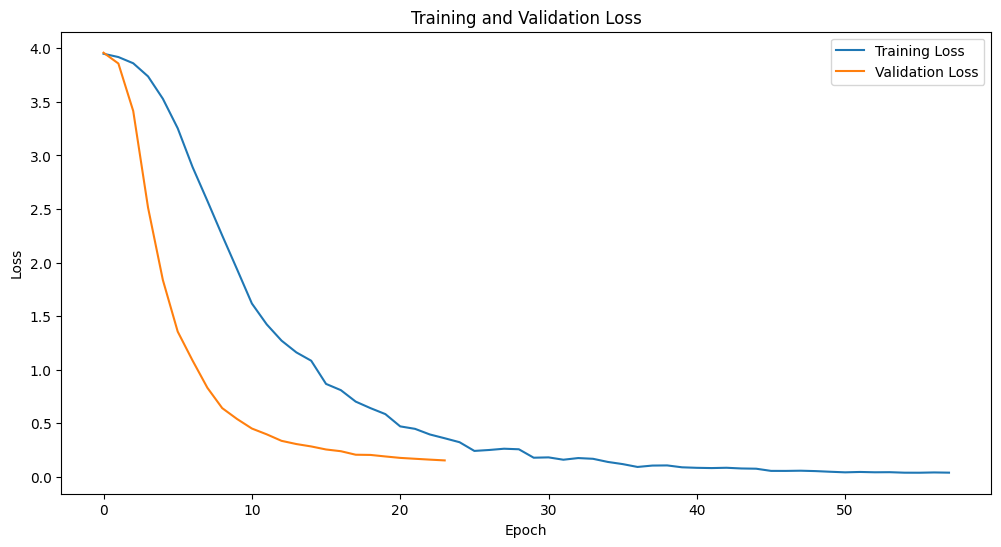

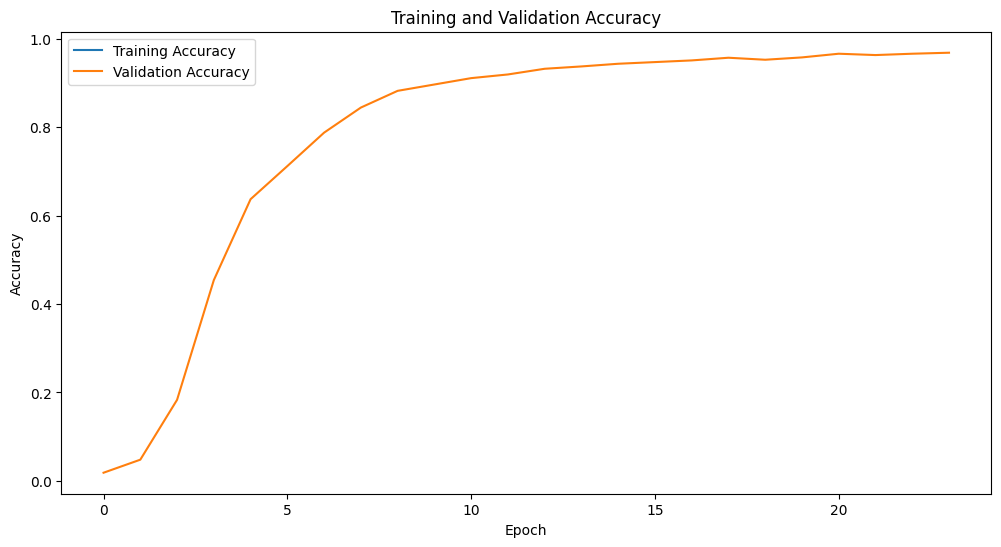

In [21]:
# Extract training and evaluation metrics
train_metrics = train_results.metrics
eval_metrics = trainer.state.log_history

# Extract loss and accuracy values
train_loss = [x["loss"] for x in eval_metrics if "loss" in x]
eval_loss = [x["eval_loss"] for x in eval_metrics if "eval_loss" in x]
train_accuracy = [x["accuracy"] for x in eval_metrics if "accuracy" in x]
eval_accuracy = [x["eval_accuracy"] for x in eval_metrics if "eval_accuracy" in x]

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig(f"{new_model_name}_loss.png")  # Save the plot as an image
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.savefig(f"{new_model_name}_accuracy.png")  # Save the plot as an image
plt.show()